# 區分鳥跟飛機

## Dataset

In [1]:
from torchvision import datasets
from torchvision import transforms

data_path = './data'

#下載訓練資料集
cifar10 = datasets.CIFAR10(  
    data_path, 
    train=True, #指定為True會下載訓練集資料
    download=True, 
    transform=transforms.ToTensor() #加上transform..這樣拿到就是tensor而不是PIL圖片
)

#下載驗證資料集..差別在於train是否為true
cifar10_val = datasets.CIFAR10(
    data_path, 
    train=False, #指定為False會下載驗證集資料
    download=True,
    transform=transforms.ToTensor()
) 

Files already downloaded and verified
Files already downloaded and verified


## 取得資料資訊

In [2]:
img, lable = cifar10[0] #取出一筆資料來觀查
img.shape #得知圖片大小為32 x 32..第0軸為三原色RGB


torch.Size([3, 32, 32])

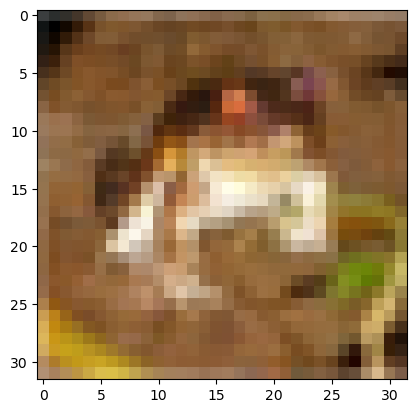

In [3]:
from matplotlib import pyplot as plt
plt.imshow(img.permute(1, 2, 0)) #將tensor的shape從C x H x W 轉成 H x W x C..才能符合plt要的格式
plt.show()

In [4]:
import torch

#將 cifar10 堆疊(stack)到一個新的軸，方便計算平均值跟誤差
imgs = torch.stack([img for img, _ in cifar10], dim=3) # dim=3代表堆疊到第3軸
imgs.shape # 得知共有50000張圖..

torch.Size([3, 32, 32, 50000])

In [5]:
# 計算每個通道的平均值.
# view 3, -1會將第0軸保留..其它的軸合併在第1軸
# 3 x 32 x 32 x 50000 會轉變成 3 x 51200000
# 再用mean遍歷第1軸計算平均值
imgs.view(3, -1).mean(dim=1) #dim=1代表mean第一軸


tensor([0.4914, 0.4822, 0.4465])

In [6]:
# 計算每個通道的標準差.
# 把mean換成std..其它原理相同
imgs.view(3, -1).std(dim=1)


tensor([0.2470, 0.2435, 0.2616])

In [7]:
# 訓練資料正規化
# 有了平均值跟標準差後.帶進transforms.Normalize就行
# Normalize的實際公式: v_n[c] = (v[c] - mean[c]) / stdev[c] 
# v_n[c]: 將v[c]正規化的結果
# v[c]: 位於通道上的某個值
# mean: 平均值
# stdev: 標準差
normalized_cifar10 = datasets.CIFAR10(
    data_path, 
    train=True, 
    download=False, #在Dataset時已經下載過..不用再下載了
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize( # 加上這裡
            (0.4914, 0.4822, 0.4465), #平均值
            (0.2470, 0.2435, 0.2616) #標準差
        )
    ])
)

# 驗證資料正規化
normalized_cifar10_val = datasets.CIFAR10(
    data_path, 
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize( # 要跟訓練資料一樣的值來做正規化
            (0.4914, 0.4822, 0.4465), #平均值
            (0.2470, 0.2435, 0.2616) #標準差
        )
    ])
)



## 從資料集中抽出鳥跟飛機

In [8]:
label_map = {0: 0, 2: 1} #將飛機map到0,鳥map到1...飛機原本剛好就為0, 鳥也剛好為1
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in normalized_cifar10 if label in[0, 2]] # 取出訓練集中的鳥跟飛機
cifar2_val = [(img, label_map[label]) for img, label in normalized_cifar10_val if label in[0, 2]] #取出驗證集中的鳥跟飛機

## 神經網路訓練

In [15]:
import torch.nn as nn
import torch.optim as optim

# model = nn.Sequential(
#     nn.Linear(3072, 512), # 3072 (3 x 32 x 32)為輸入特徵數..512為輸出特徵數
#     nn.Tanh(), # Activite function
#     nn.Linear(512, 2),
#     nn.LogSoftmax(dim=1) #將輸出轉換成機率
# )

# model = nn.Sequential(
#     nn.Linear(3072, 1024),
#     nn.Tanh(),
#     nn.Linear(1024, 512),
#     nn.Tanh(),
#     nn.Linear(512, 2),
#     nn.LogSoftmax(dim=1) #將輸出轉換成機率
# )

model = nn.Sequential(
    nn.Linear(3072, 1024), 
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1) #將輸出轉換成機率
)

# 學習率
learning_rate = 0.01

# Stochastic Gradient Descent(SGD)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# loss function 
loss_fn = nn.NLLLoss() # negative log likelihood

n_epochs = 100

for epoch in range(n_epochs):
    train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
    for imgs, labels in train_loader:
        batch_size=imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.539860
Epoch: 1, Loss: 0.298767
Epoch: 2, Loss: 0.623125
Epoch: 3, Loss: 0.432798
Epoch: 4, Loss: 0.318230
Epoch: 5, Loss: 0.848618
Epoch: 6, Loss: 0.426792
Epoch: 7, Loss: 0.477694
Epoch: 8, Loss: 0.312239
Epoch: 9, Loss: 0.216247
Epoch: 10, Loss: 0.429345
Epoch: 11, Loss: 0.387021
Epoch: 12, Loss: 0.540357
Epoch: 13, Loss: 0.110712
Epoch: 14, Loss: 0.432548
Epoch: 15, Loss: 0.221295
Epoch: 16, Loss: 0.174805
Epoch: 17, Loss: 0.394944
Epoch: 18, Loss: 0.435774
Epoch: 19, Loss: 0.331669
Epoch: 20, Loss: 0.218688
Epoch: 21, Loss: 0.161846
Epoch: 22, Loss: 0.462144
Epoch: 23, Loss: 0.222880
Epoch: 24, Loss: 0.364210
Epoch: 25, Loss: 0.145831
Epoch: 26, Loss: 0.194491
Epoch: 27, Loss: 0.240990
Epoch: 28, Loss: 0.319745
Epoch: 29, Loss: 0.500974
Epoch: 30, Loss: 0.269555
Epoch: 31, Loss: 0.103343
Epoch: 32, Loss: 0.081421
Epoch: 33, Loss: 0.089222
Epoch: 34, Loss: 0.111389
Epoch: 35, Loss: 0.105613
Epoch: 36, Loss: 0.680290
Epoch: 37, Loss: 0.055938
Epoch: 38, Loss: 0.226

In [16]:
#用驗證集的樣本來計算準確率
correct = 0
total = 0
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False) #驗證資料不shuffle..
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1) #取出機率最大的
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.808000
